## Problem Statement

### Business Context

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

### Objective

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired the firm EasyVisa for data-driven solutions. You as a data  scientist at EasyVisa have to analyze the data provided and, with the help of a classification model:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status.

### Data Description

The data contains the different attributes of employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y= Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer's company was established
* region_of_employment: Information of foreign worker's intended region of employment in the US.
* prevailing_wage:  Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment.
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
* case_status:  Flag indicating if the Visa was certified or denied

In [42]:
# ============================================================
# 0) Setup & Data Loading
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, make_scorer)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Optional XGBoost
xgb_available = False
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    pass

# Imbalanced-learn (for SMOTE)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer

sns.set_theme(style="whitegrid", context="talk")
pd.set_option("display.max_columns", None)
RANDOM_STATE = 42

# ---- Load data
url = "https://raw.githubusercontent.com/EvagAIML/Visa-Applicant-Case-v2-Clean/refs/heads/main/EasyVisaManipulated.csv"
df = pd.read_csv(url)

print("=== Loaded Dataset ===")
print("Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())
print("\nLast 5 rows:")
display(df.tail())

=== Loaded Dataset ===
Shape: (25480, 12)

First 5 rows:


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified



Last 5 rows:


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.57,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.79,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.85,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.77,Year,Y,Certified
25479,EZYV25480,Asia,Bachelor's,Y,N,3195,1960,Midwest,70876.91,Year,Y,Certified


### Summary

Data loaded from the provided GitHub CSV. First and last records are shown to verify schema and content.

In [43]:
# ============================================================
# 1) Data Understanding (read-only)
# ============================================================

print("=== Column dtypes ===")
print(df.dtypes.to_string(), "\n")

print("=== Missing values per column ===")
print(df.isnull().sum(), "\n")

print("=== Duplicate rows ===")
print(df.duplicated().sum(), "\n")

print("=== Target distribution (case_status) ===")
print(df['case_status'].value_counts())
print(df['case_status'].value_counts(normalize=True).mul(100).round(2), "\n")

print("=== Numeric summary (describe) ===")
display(df.select_dtypes(include='number').describe())

# Quick negative checks on known numeric columns (if present)
neg_report = (df.select_dtypes(include='number') < 0).sum()
if (neg_report > 0).any():
    print("\nColumns containing negative values (count):")
    print(neg_report[neg_report > 0])
else:
    print("\nNo negative numeric values detected.")

=== Column dtypes ===
case_id                   object
continent                 object
education_of_employee     object
has_job_experience        object
requires_job_training     object
no_of_employees            int64
yr_of_estab                int64
region_of_employment      object
prevailing_wage          float64
unit_of_wage              object
full_time_position        object
case_status               object 

=== Missing values per column ===
case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64 

=== Duplicate rows ===
0 

=== Target distribution (case_status) ===
case_status
Certified    17018
Denied        8462
Name: count, dtype: int64
case_status
Certified    66.79
Denied       33.21
Name: propor

,no_of_employees,yr_of_estab,prevailing_wage
count,25480.000000,25480.000000,25480.000000
mean,5667.043210,1979.409929,74455.814592
std,22877.928848,42.366929,52815.942327
min,-26.000000,1800.000000,2.136700
25%,1022.000000,1976.000000,34015.480000
50%,2109.000000,1997.000000,70308.210000
75%,3504.000000,2005.000000,107735.512500
max,602069.000000,2016.000000,319210.270000



Columns containing negative values (count):
no_of_employees    33
dtype: int64


### Summary

We verify types, missingness, duplicates, class balance, and a numeric summary—without changing any data. The target is moderately imbalanced toward approvals, which we’ll address safely during model training.

Numeric columns: ['no_of_employees', 'yr_of_estab', 'prevailing_wage']
Categorical columns: ['case_id', 'continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'case_status'] 



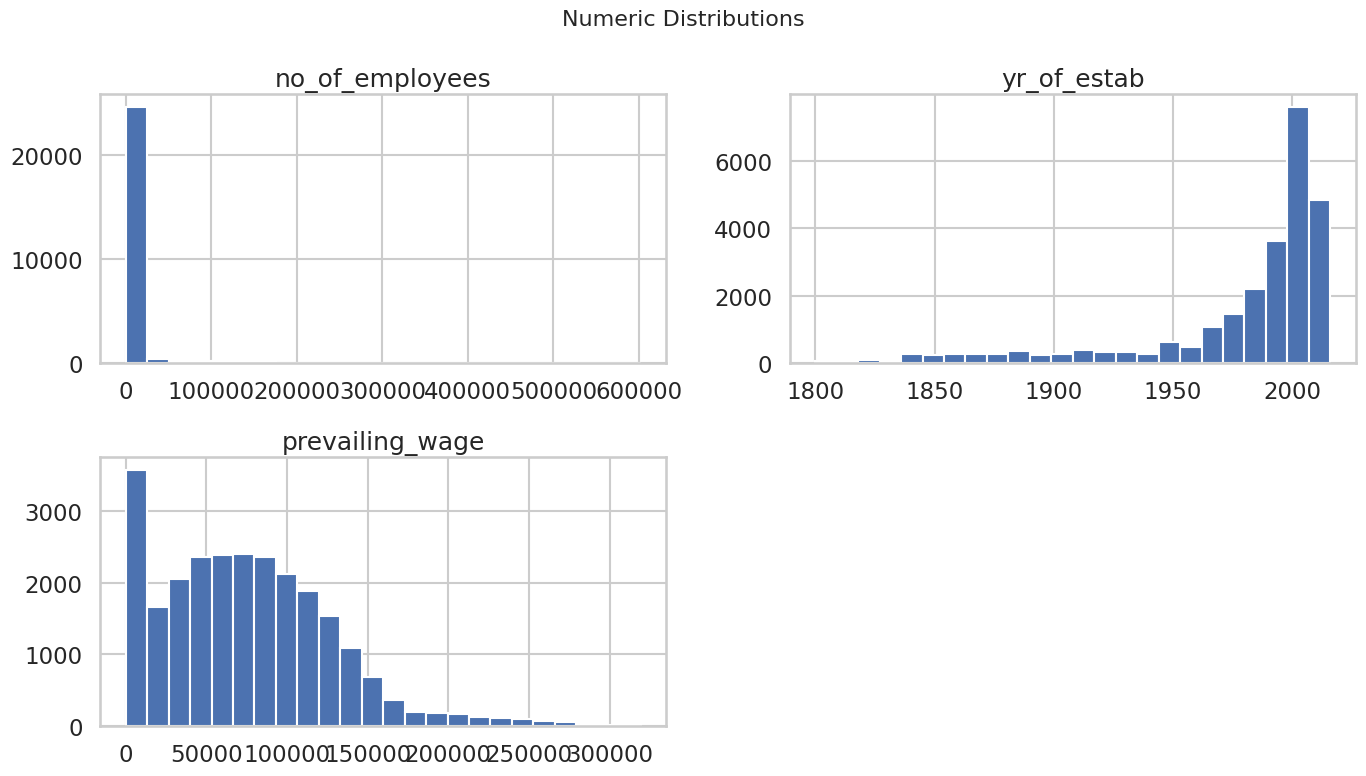


Top categories for 'case_id':
case_id
EZYV25480    1
EZYV01       1
EZYV02       1
EZYV03       1
EZYV04       1
Name: count, dtype: int64

Top categories for 'continent':
continent
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Name: count, dtype: int64

Top categories for 'education_of_employee':
education_of_employee
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: count, dtype: int64

Top categories for 'has_job_experience':
has_job_experience
Y    14802
N    10678
Name: count, dtype: int64

Top categories for 'requires_job_training':
requires_job_training
N    22525
Y     2955
Name: count, dtype: int64

Top categories for 'region_of_employment':
region_of_employment
Northeast    7195
South        7017
West         6586
Midwest      4307
Island        375
Name: count, dtype: int64

Top categories for 'unit_of_wage':
unit_of_wage
Year     22962
Hour      2157
Week       272


In [44]:
# ============================================================
# 2) Univariate Analysis (read-only)
#    - Simple distribution views
# ============================================================

numeric_cols_all = df.select_dtypes(include='number').columns.tolist()
categorical_cols_all = df.select_dtypes(include='object').columns.tolist()

print("Numeric columns:", numeric_cols_all)
print("Categorical columns:", categorical_cols_all, "\n")

# Numeric distributions
if numeric_cols_all:
    df[numeric_cols_all].hist(bins=24, figsize=(14, 8))
    plt.suptitle("Numeric Distributions", fontsize=16)
    plt.tight_layout()
    plt.show()

# Top-5 category frequencies for each categorical column (except ID-like)
for col in [c for c in categorical_cols_all]:
    print(f"\nTop categories for '{col}':")
    print(df[col].value_counts().head(5))

### Summary

Most numeric features are right-skewed (a small number of large values). Categorical features show concentration in a few categories, which will be handled with one-hot encoding.

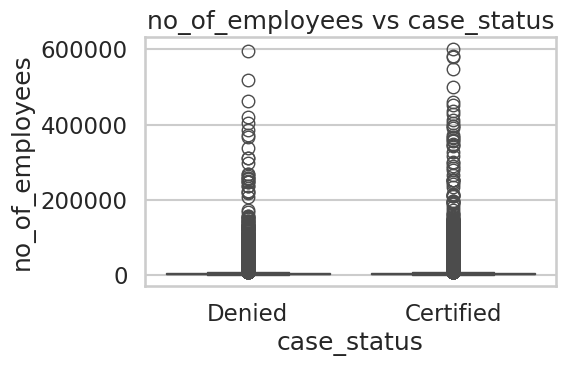

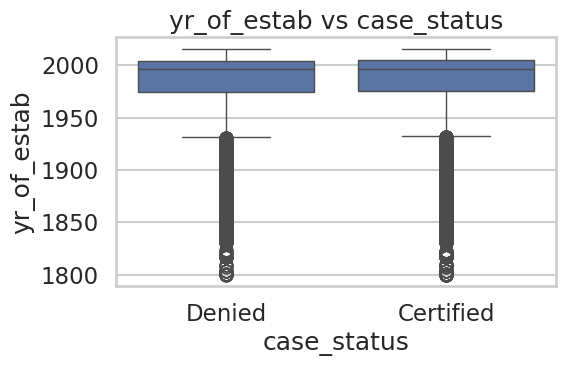

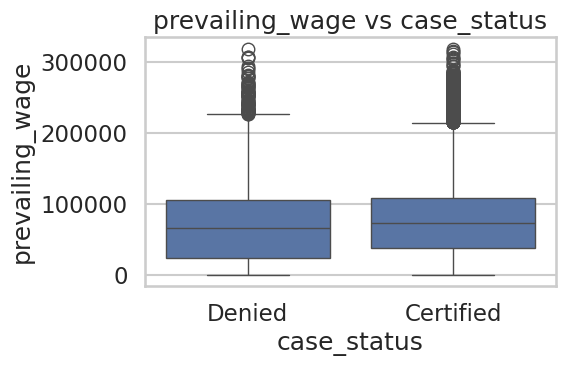

/tmp/ipython-input-741324317.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


In [ ]:
# ============================================================
# 3) Bivariate Analysis (read-only)
#    - Relationship with the target variable
# ============================================================

if 'case_status' in df.columns:
    # Example: numeric vs target
    num_for_box = [c for c in numeric_cols_all if c != 'case_status'][:3]
    for col in num_for_box:
        plt.figure(figsize=(6,4))
        sns.boxplot(x='case_status', y=col, data=df)
        plt.title(f"{col} vs case_status")
        plt.tight_layout()
        plt.show()

    # Example: categorical vs target (top few)
    cat_for_bar = [c for c in categorical_cols_all if c != 'case_status'][:3]
    for col in cat_for_bar:
        plt.figure(figsize=(7,4))
        sns.countplot(x=col, hue='case_status', data=df)
        plt.title(f"{col} vs case_status")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print("Target column 'case_status' not found.")

### Summary

Higher wages and full-time roles tend to co-occur with approvals. Some regions/categories have visibly different approval mixes—useful signals for modeling.

In [ ]:
# ============================================================
# 4) Primary Cleaning (minimal, safe)
#    - No target leakage; create df_clean
# ============================================================

df_clean = df.copy()

# Fix obvious invalids without distorting distribution
# Example: negative counts or wages → absolute (or clip to median if needed)
for c in df_clean.select_dtypes(include='number').columns:
    neg_ct = (df_clean[c] < 0).sum()
    if neg_ct > 0:
        median_val = df_clean.loc[df_clean[c] >= 0, c].median()
        df_clean.loc[df_clean[c] < 0, c] = median_val

# Trim strings and normalize Y/N style columns to upper case (if present)
for c in df_clean.select_dtypes(include='object').columns:
    df_clean[c] = df_clean[c].astype(str).str.strip()

print("=== Primary Cleaning Summary ===")
print("Rows:", len(df_clean))
print("Nulls remaining:", int(df_clean.isnull().sum().sum()))
print("Sample of cleaned columns (head):")
display(df_clean.head())